In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load model

In [25]:
# https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Load data clean

In [26]:
# Load the CSV file into a DataFrame
df_de = pd.read_csv('../Preprocessing/data_clean/de_clean_1.csv')
df_en = pd.read_csv('../Preprocessing/data_clean/en_clean_1.csv')
df_es = pd.read_csv('../Preprocessing/data_clean/es_clean_1.csv')

### DE fix

In [27]:
#for DE datasate drop empty lines
df_de = df_de.dropna(subset=['data'])


### Hincapié fix

In [28]:
# Replace 'Piero Hincapié' with 'Piero Hincapie' in the 'player' column
df_es['player'] = df_es['player'].replace('Piero Hincapié', 'Piero Hincapie')
df_en['player'] = df_en['player'].replace('piero hincapié', 'piero hincapie')


# Sentiment Analysis

In [29]:
def sentiment_score(data):
    if isinstance(data, str):
        tokens = tokenizer.encode(data, return_tensors='pt')
        result = model(tokens)
        return int(torch.argmax(result.logits)) + 1
    else:
        return 0

In [30]:
df_de['sentiment'] = df_de['data'].apply(lambda x: sentiment_score(x[:512]))
df_en['sentiment'] = df_en['data'].apply(lambda x: sentiment_score(x[:512]))
df_es['sentiment'] = df_es['data'].apply(lambda x: sentiment_score(x[:512]))

In [31]:
# Grouping the data by 'player' and calculating the mean of 'sentiment' for each player
mean_sentiment_de = df_de.groupby('player')['sentiment'].mean()
mean_sentiment_en = df_en.groupby('player')['sentiment'].mean()
mean_sentiment_es = df_es.groupby('player')['sentiment'].mean()

print('Sentiment score per player DE')
print(mean_sentiment_de)
print('Sentiment score per player EN')
print(mean_sentiment_en)
print('Sentiment score per player ES')
print(mean_sentiment_es)

Sentiment score per player DE
player
exequiel palacios    1.608247
jeremie frimpong     1.811966
jonathan tah         1.784091
mitchel bakker       1.677083
moussa diaby         1.760331
mykhaylo mudryk      1.000000
piero hincapie       1.623529
Name: sentiment, dtype: float64
Sentiment score per player EN
player
exequiel palacios    2.958333
jeremie frimpong     2.666667
jonathan tah         3.142857
mitchel bakker       2.777778
moussa diaby         2.698925
mykhaylo mudryk      2.692308
piero hincapie       2.260870
Name: sentiment, dtype: float64
Sentiment score per player ES
player
Exequiel Palacios    2.927835
Jeremie Frimpong     2.956522
Jonathan Tah         2.833333
Mitchel Bakker       2.818182
Moussa Diaby         2.548387
Mykhaylo Mudryk      1.962963
Piero Hincapie       3.217949
Name: sentiment, dtype: float64


# Player sentence analysis

In [32]:
def extract_sentence(df):
    df['short'] = ''
    
    for index, row in df.iterrows():
        player = row['player']
        data = str(row['data'])  # Convert data to string
        
        # Find the sentence containing player's information
        sentences = data.split('.')
        for sentence in sentences:
            if player.lower() in sentence.lower():
                df.at[index, 'short'] = sentence.strip()
                break
    
    return df

In [33]:
extract_sentence(df_de)
extract_sentence(df_en)
extract_sentence(df_es)

,data,player,language,publishedAt,sentiment,short
0,"Mercado de fichajes de fútbol, en directo Con...",Exequiel Palacios,es,2023-01-29T18:25:03Z,2,"Mercado de fichajes de fútbol, en directo Con..."
1,La última semana de marzo es la primera ventan...,Exequiel Palacios,es,2023-01-30T16:52:46Z,2,"Además de Messi y Ángel Di María, máximos refe..."
2,Gustavo Puerta ya no jugará en el Bayer Leverk...,Exequiel Palacios,es,2023-01-31T20:41:38Z,2,"El club alemán, que siempre se ha caracterizad..."
3,"Alberto Fernández El presidente de la AFA, Cl...",Exequiel Palacios,es,2023-02-09T18:32:38Z,3,"Alberto Fernández El presidente de la AFA, Cl..."
4,Alberto Fernández También participaron los ot...,Exequiel Palacios,es,2023-02-12T21:13:55Z,4,Alberto Fernández También participaron los ot...
...,...,...,...,...,...,...
268,"Antes del minuto, el visitante ya había llegad...",Piero Hincapie,es,2023-05-11T21:13:48Z,1,
269,El Bayer Leverkusen jugó de visita contra la R...,Piero Hincapie,es,2023-05-11T20:56:21Z,3,
270,Un ecuatoriano volverá a semifinales de un tor...,Piero Hincapie,es,2023-05-11T18:30:25Z,4,
271,La Selección de Ecuador jugará sus dos últimos...,Piero Hincapie,es,2023-05-10T23:37:55Z,3,


In [34]:
df_de['sentiment2'] = df_de['short'].apply(lambda x: sentiment_score(x[:512]))
df_en['sentiment2'] = df_en['short'].apply(lambda x: sentiment_score(x[:512]))
df_es['sentiment2'] = df_es['short'].apply(lambda x: sentiment_score(x[:512]))

In [35]:
# Grouping the data by 'player' and calculating the mean of 'sentiment' for each player
mean_sentiment_de = df_de.groupby('player')['sentiment2'].mean()
mean_sentiment_en = df_en.groupby('player')['sentiment2'].mean()
mean_sentiment_es = df_es.groupby('player')['sentiment2'].mean()

print('Sentiment score per player DE')
print(mean_sentiment_de)
print('Sentiment score per player EN')
print(mean_sentiment_en)
print('Sentiment score per player ES')
print(mean_sentiment_es)

Sentiment score per player DE
player
exequiel palacios    1.896907
jeremie frimpong     2.350427
jonathan tah         2.363636
mitchel bakker       2.302083
moussa diaby         2.272727
mykhaylo mudryk      1.166667
piero hincapie       2.200000
Name: sentiment2, dtype: float64
Sentiment score per player EN
player
exequiel palacios    2.250000
jeremie frimpong     2.839506
jonathan tah         3.571429
mitchel bakker       2.333333
moussa diaby         3.075269
mykhaylo mudryk      2.865385
piero hincapie       3.000000
Name: sentiment2, dtype: float64
Sentiment score per player ES
player
Exequiel Palacios    3.226804
Jeremie Frimpong     3.173913
Jonathan Tah         3.000000
Mitchel Bakker       2.272727
Moussa Diaby         2.580645
Mykhaylo Mudryk      2.407407
Piero Hincapie       3.858974
Name: sentiment2, dtype: float64


/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['publishedAt'] = pd.to_datetime(player_df['publishedAt'])
/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df.sort_values('publishedAt', inplace=True)


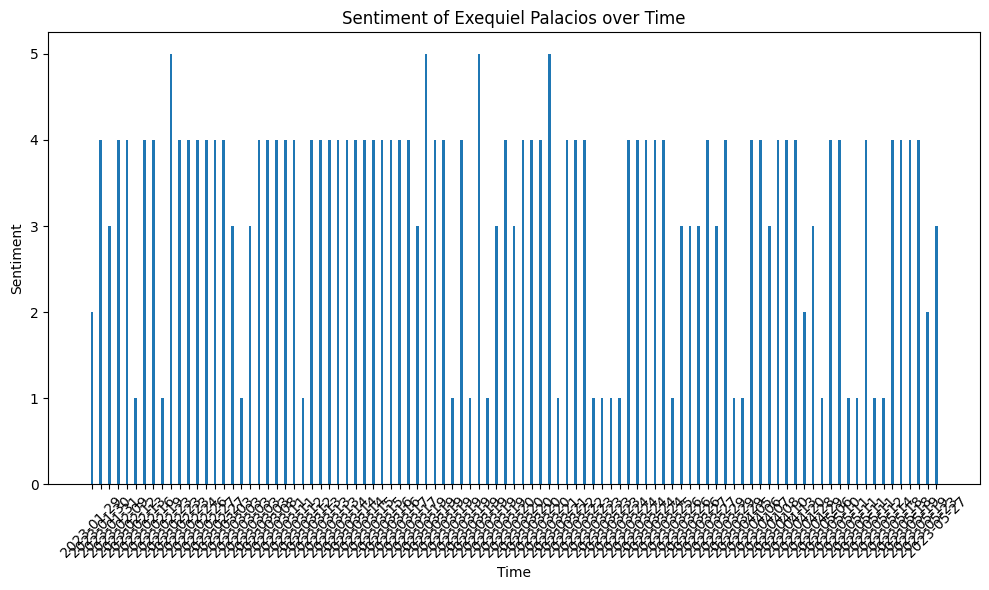

/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['publishedAt'] = pd.to_datetime(player_df['publishedAt'])
/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df.sort_values('publishedAt', inplace=True)


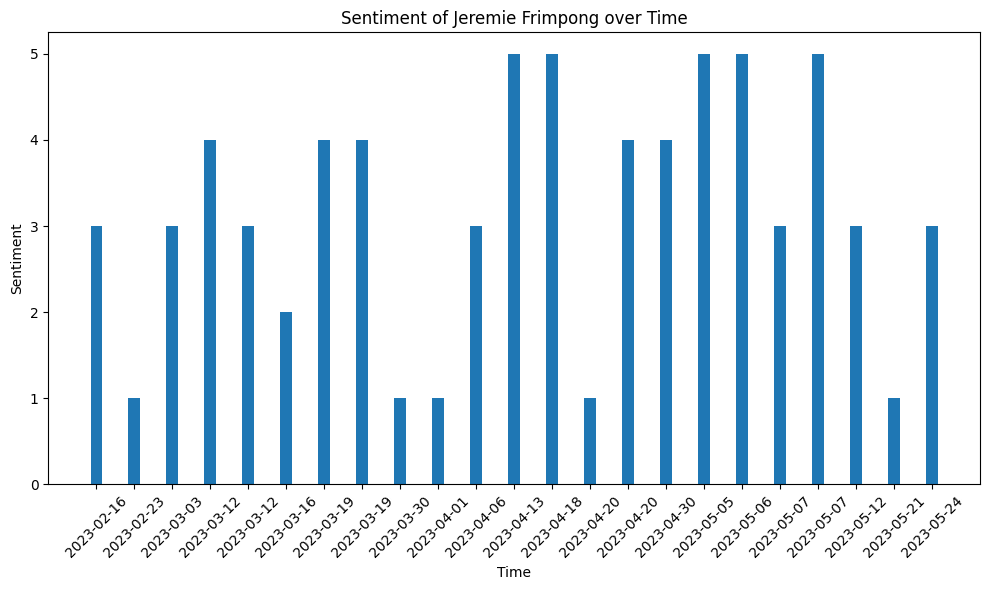

/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['publishedAt'] = pd.to_datetime(player_df['publishedAt'])
/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df.sort_values('publishedAt', inplace=True)


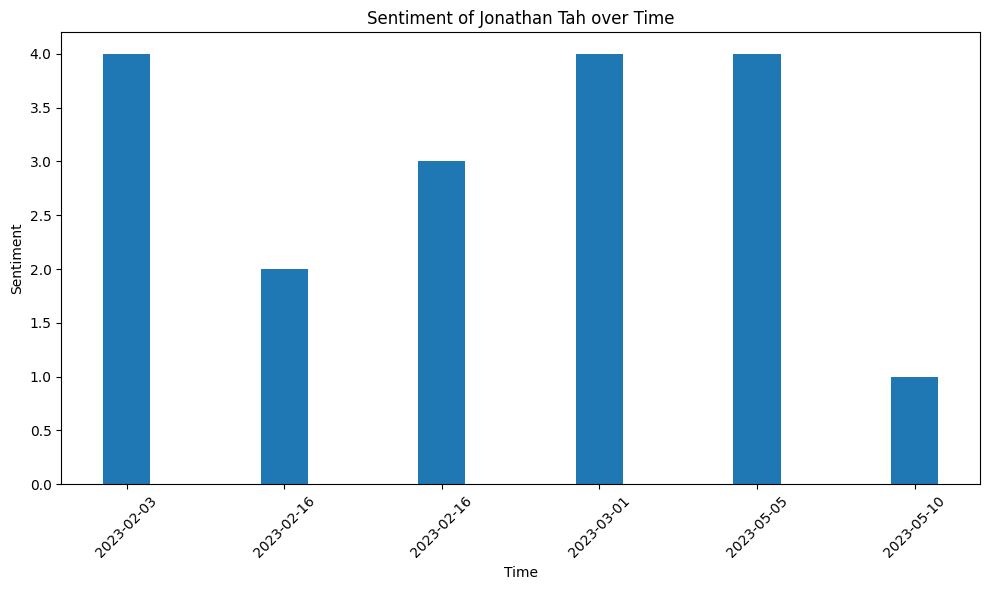

/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['publishedAt'] = pd.to_datetime(player_df['publishedAt'])
/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df.sort_values('publishedAt', inplace=True)


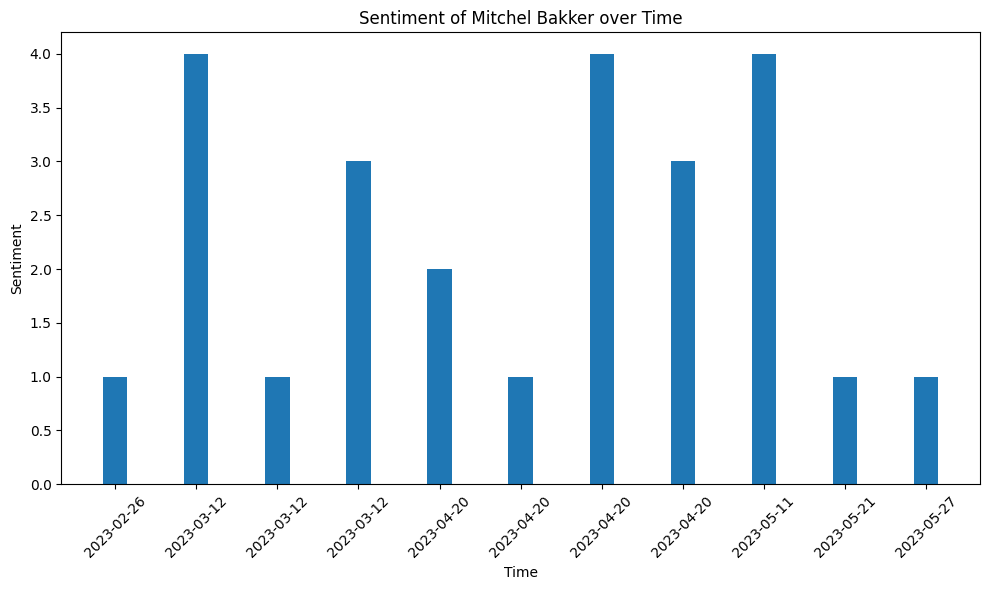

/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['publishedAt'] = pd.to_datetime(player_df['publishedAt'])
/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df.sort_values('publishedAt', inplace=True)


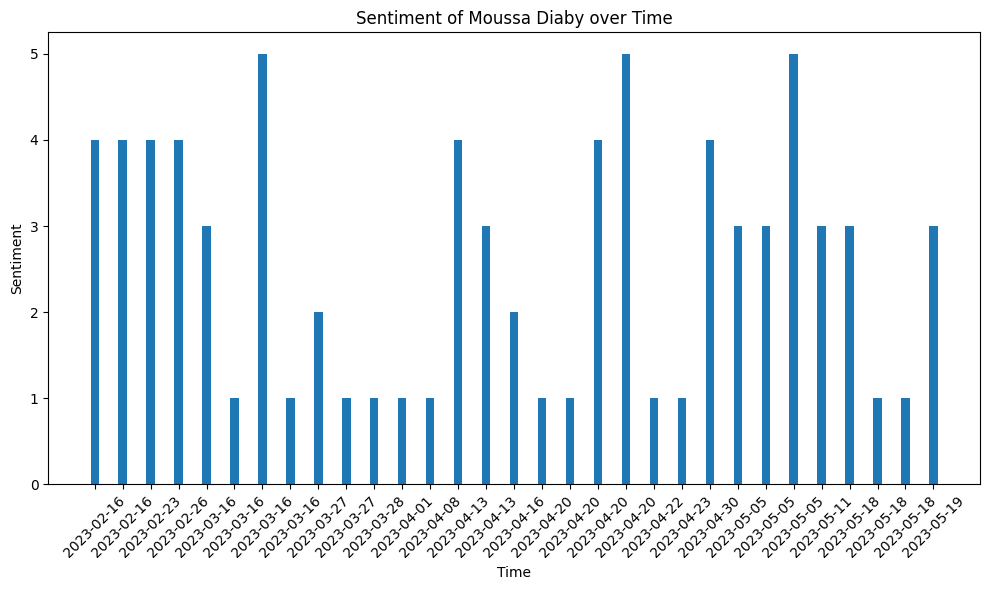

/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['publishedAt'] = pd.to_datetime(player_df['publishedAt'])
/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df.sort_values('publishedAt', inplace=True)


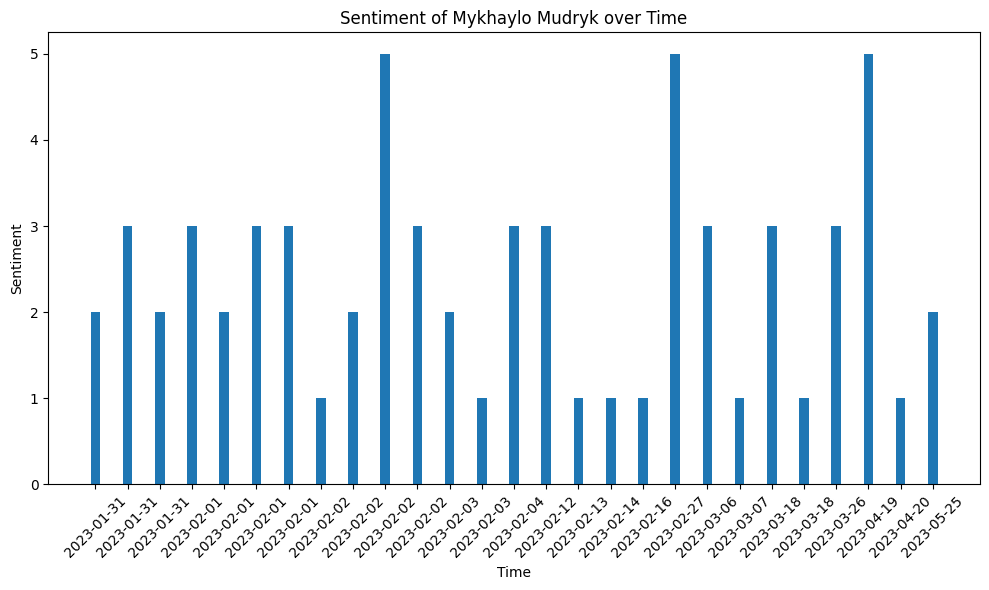

/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['publishedAt'] = pd.to_datetime(player_df['publishedAt'])
/var/folders/fq/0lb0fh614nz4_s73hrgyrcd00000gn/T/ipykernel_56119/1624906248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df.sort_values('publishedAt', inplace=True)


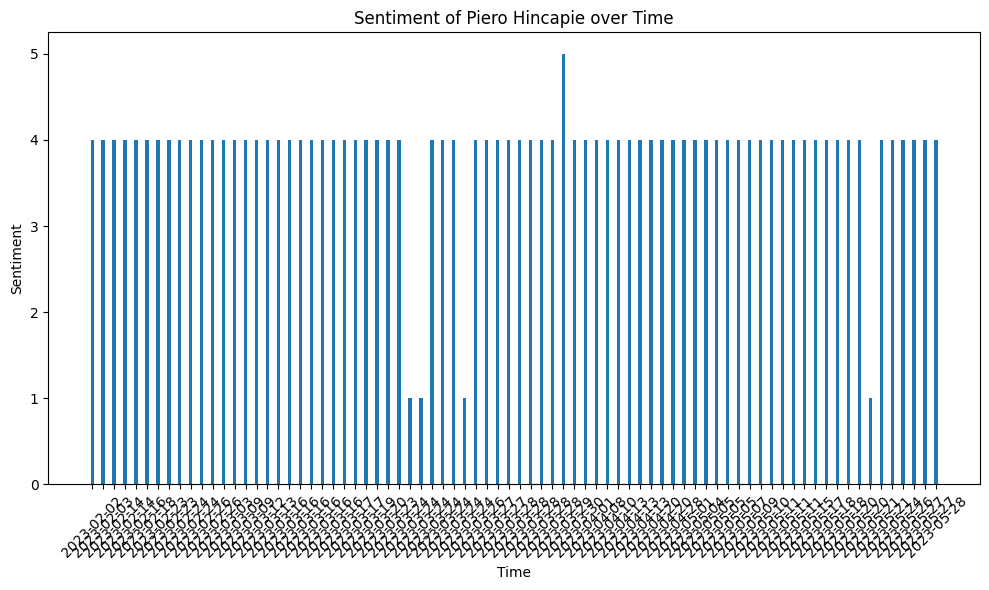

In [56]:
# Filter rows for each player and plot sentiment over time
players = df_es['player'].unique()  # Get unique player names

# Set the width of each bar
bar_width = 0.3

# Create separate bar graphs for each player
for player in players:
    player_df = df_es[df_es['player'] == player]
    player_df['publishedAt'] = pd.to_datetime(player_df['publishedAt'])
    player_df.sort_values('publishedAt', inplace=True)

    # Set the position of each bar on the x-axis
    x = range(len(player_df['publishedAt']))

    # Plot sentiment over time for each player using bars
    plt.figure(figsize=(10, 6))
    plt.bar(x, player_df['sentiment2'], width=bar_width)
    plt.title(f'Sentiment of {player} over Time')
    plt.xlabel('Time')
    plt.ylabel('Sentiment')
    plt.xticks(x, player_df['publishedAt'].dt.strftime('%Y-%m-%d'), rotation=45)
    plt.tight_layout()
    plt.show()

